In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    """
    For a given observation, compute Q values for each action
        Attributes
    ----------
    lr: float
        learning rate
    input_dims : list
        [8]
    fc1_dims : int
        fully-connected layer 1
    fc2_dims : int
        fully-connected layer 2
    n_actions : int
        the number of actions
    """
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, weight_decay=1e-5,p=0.5):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
#        self.dropout = nn.Dropout(p) 
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
#        self.loss = nn.MSELoss()
        self.loss = nn.SmoothL1Loss() # Huber loss
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
#        x = self.dropout(x) # dropout for regularization
        actions = self.fc3(x)
        
        return actions

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                max_mem_size=100000, eps_end=0.01, eps_dec=1e-5, weight_decay=1e-5):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)] # list of actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, 
                                  fc1_dims=32, fc2_dims=32, weight_decay=weight_decay)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype= np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # residual. The memory is finite, so we are reusing
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] =  action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
        
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device) # [] is used because of the nn library. torch.Size([1, 6])
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item() # .item() to get integer
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size) 
        # select samples the number of self.batch_size out of max_mem 
        batch = np.random.choice(max_mem, self.batch_size, replace=False) # Don't select the same thing again
        # array slicing [0,1,2,...,self.batch_size-1]
        batch_index = np.arange(self.batch_size, dtype=np.int32) 
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
                                                 
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        

In [2]:
from env import TradingSPYEnv
#from env2 import TradingSPYEnv
import numpy as np
env = TradingSPYEnv(init_invest=100.0, sma_len=[5,25,50,100])
num_states = len(env.reset())
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))

agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=num_actions, eps_end=0.01, input_dims = [num_states], lr=0.003,
              weight_decay=1e-5)
scores, eps_history = [], []
n_games = 1000


for i in range(n_games):
    score = 0.0
    done = False
    observation = env.reset()
    if observation.dtype == np.float64:
        observation = observation.astype(np.float32)
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        if (observation_ is not None): 
            if (observation_.dtype == np.float64):
                observation_ = observation_.astype(np.float32)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    
    avg_score = np.mean(scores[-100:])
    
    print('episode ', i, 'score %.2f' % score,
         'average score %.2f' % avg_score,
         'epsilon %.2f ' % agent.epsilon,
         'profit_iteration %.2f ' % info['profit_iteration'],
         'iterations %.2f ' % info['iterations'],
         'long_return %.2f ' % info['long_return']
         )


C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Size of State Space ->  8
Size of Action Space ->  3
episode  0 score 120.36 average score 120.36 epsilon 0.97  profit_iteration 0.04  iterations 3120.00  long_return 2.76 
episode  1 score 104.61 average score 112.48 epsilon 0.94  profit_iteration 0.04  iterations 2768.00  long_return 2.24 
episode  2 score -18.47 average score 68.83 epsilon 0.94  profit_iteration -0.03  iterations 632.00  long_return 1.46 
episode  3 score -27.69 average score 44.70 epsilon 0.92  profit_iteration -0.02  iterations 1303.00  long_return 1.88 
episode  4 score -25.20 average score 30.72 epsilon 0.91  profit_iteration -0.02  iterations 1474.00  long_return 2.21 
episode  5 score 21.52 average score 29.19 epsilon 0.90  profit_iteration 0.03  iterations 657.00  long_return 1.40 
episode  6 score -3.90 average score 24.46 epsilon 0.89  profit_iteration -0.01  iterations 712.00  long_return 1.49 
episode  7 score -19.77 average score 18.93 epsilon 0.86  profit_iteration -0.01  iterations 3361.00  long_return

episode  69 score 118.03 average score 32.69 epsilon 0.01  profit_iteration 0.04  iterations 3206.00  long_return 3.06 
episode  70 score 73.38 average score 33.26 epsilon 0.01  profit_iteration 0.05  iterations 1386.00  long_return 2.12 
episode  71 score 43.67 average score 33.40 epsilon 0.01  profit_iteration 0.07  iterations 615.00  long_return 1.50 
episode  72 score 257.67 average score 36.48 epsilon 0.01  profit_iteration 0.08  iterations 3388.00  long_return 3.11 
episode  73 score 48.79 average score 36.64 epsilon 0.01  profit_iteration 0.08  iterations 616.00  long_return 1.50 
episode  74 score 186.83 average score 38.65 epsilon 0.01  profit_iteration 0.06  iterations 3319.00  long_return 3.08 
episode  75 score 184.94 average score 40.57 epsilon 0.01  profit_iteration 0.09  iterations 2044.00  long_return 2.95 
episode  76 score 10.52 average score 40.18 epsilon 0.01  profit_iteration 0.05  iterations 198.00  long_return 1.13 
episode  77 score 208.53 average score 42.34 ep

episode  138 score 231.39 average score 115.01 epsilon 0.01  profit_iteration 0.10  iterations 2291.00  long_return 3.53 
episode  139 score 180.35 average score 116.68 epsilon 0.01  profit_iteration 0.05  iterations 3550.00  long_return 3.29 
episode  140 score 27.45 average score 116.37 epsilon 0.01  profit_iteration 0.07  iterations 383.00  long_return 1.27 
episode  141 score 223.51 average score 118.27 epsilon 0.01  profit_iteration 0.11  iterations 1992.00  long_return 2.98 
episode  142 score 252.84 average score 121.29 epsilon 0.01  profit_iteration 0.07  iterations 3473.00  long_return 3.30 
episode  143 score 119.37 average score 122.72 epsilon 0.01  profit_iteration 0.06  iterations 1819.00  long_return 2.46 
episode  144 score 166.24 average score 123.71 epsilon 0.01  profit_iteration 0.10  iterations 1675.00  long_return 2.55 
episode  145 score 183.88 average score 125.43 epsilon 0.01  profit_iteration 0.07  iterations 2496.00  long_return 2.61 
episode  146 score 156.85 

episode  206 score 202.38 average score 148.69 epsilon 0.01  profit_iteration 0.06  iterations 3594.00  long_return 3.26 
episode  207 score 127.63 average score 149.67 epsilon 0.01  profit_iteration 0.04  iterations 3096.00  long_return 2.73 
episode  208 score 295.08 average score 151.16 epsilon 0.01  profit_iteration 0.07  iterations 3999.00  long_return 3.97 
episode  209 score 41.45 average score 148.89 epsilon 0.01  profit_iteration 0.05  iterations 862.00  long_return 1.44 
episode  210 score 199.04 average score 150.79 epsilon 0.01  profit_iteration 0.06  iterations 3514.00  long_return 3.35 
episode  211 score 142.07 average score 150.58 epsilon 0.01  profit_iteration 0.05  iterations 2770.00  long_return 2.29 
episode  212 score 36.53 average score 149.01 epsilon 0.01  profit_iteration 0.05  iterations 750.00  long_return 1.38 
episode  213 score 200.31 average score 149.68 epsilon 0.01  profit_iteration 0.05  iterations 3631.00  long_return 3.23 
episode  214 score 145.22 av

episode  274 score 153.23 average score 139.46 epsilon 0.01  profit_iteration 0.08  iterations 1840.00  long_return 2.51 
episode  275 score 378.47 average score 141.70 epsilon 0.01  profit_iteration 0.15  iterations 2447.00  long_return 3.43 
episode  276 score 38.30 average score 140.32 epsilon 0.01  profit_iteration 0.08  iterations 468.00  long_return 1.32 
episode  277 score 303.07 average score 142.12 epsilon 0.01  profit_iteration 0.08  iterations 3849.00  long_return 4.30 
episode  278 score 74.27 average score 141.64 epsilon 0.01  profit_iteration 0.06  iterations 1241.00  long_return 1.80 
episode  279 score 230.53 average score 141.34 epsilon 0.01  profit_iteration 0.10  iterations 2319.00  long_return 3.85 
episode  280 score 223.24 average score 142.30 epsilon 0.01  profit_iteration 0.07  iterations 3062.00  long_return 2.72 
episode  281 score 135.85 average score 141.73 epsilon 0.01  profit_iteration 0.05  iterations 2566.00  long_return 2.43 
episode  282 score 218.40 a

C:\Users\golde\Documents\GitHub\projects\practices\reinforcement learning\stock_env\env.py:136: RuntimeWarning: invalid value encountered in double_scalars
  return None, None, done, {'profit_iteration': self.accumulated_profit/self.iteration, 'iterations': self.iteration,


episode  306 score 213.98 average score 145.59 epsilon 0.01  profit_iteration 0.06  iterations 3631.00  long_return 3.23 
episode  307 score 268.75 average score 147.00 epsilon 0.01  profit_iteration 0.07  iterations 3730.00  long_return 3.61 
episode  308 score 34.42 average score 144.40 epsilon 0.01  profit_iteration 0.06  iterations 533.00  long_return 1.38 
episode  309 score 178.13 average score 145.77 epsilon 0.01  profit_iteration 0.09  iterations 1968.00  long_return 2.88 
episode  310 score 267.46 average score 146.45 epsilon 0.01  profit_iteration 0.07  iterations 3557.00  long_return 3.35 
episode  311 score 15.35 average score 145.18 epsilon 0.01  profit_iteration 0.07  iterations 214.00  long_return 1.14 
episode  312 score 177.69 average score 146.59 epsilon 0.01  profit_iteration 0.05  iterations 3485.00  long_return 3.26 
episode  313 score 332.83 average score 147.92 epsilon 0.01  profit_iteration 0.09  iterations 3876.00  long_return 4.39 
episode  314 score 28.57 ave

episode  374 score 182.22 average score 154.00 epsilon 0.01  profit_iteration 0.09  iterations 2093.00  long_return 2.81 
episode  375 score 168.43 average score 151.90 epsilon 0.01  profit_iteration 0.06  iterations 2918.00  long_return 2.48 
episode  376 score 111.68 average score 152.63 epsilon 0.01  profit_iteration 0.07  iterations 1556.00  long_return 2.26 
episode  377 score 127.27 average score 150.88 epsilon 0.01  profit_iteration 0.05  iterations 2630.00  long_return 2.55 
episode  378 score 68.91 average score 150.82 epsilon 0.01  profit_iteration 0.06  iterations 1086.00  long_return 1.62 
episode  379 score 133.81 average score 149.86 epsilon 0.01  profit_iteration 0.09  iterations 1509.00  long_return 2.33 
episode  380 score 447.89 average score 152.10 epsilon 0.01  profit_iteration 0.19  iterations 2357.00  long_return 4.76 
episode  381 score 173.20 average score 152.48 epsilon 0.01  profit_iteration 0.08  iterations 2161.00  long_return 3.01 
episode  382 score 314.03

episode  442 score 341.25 average score 151.99 epsilon 0.01  profit_iteration 0.09  iterations 3909.00  long_return 4.27 
episode  443 score 220.87 average score 153.44 epsilon 0.01  profit_iteration 0.11  iterations 2056.00  long_return 2.82 
episode  444 score 213.98 average score 153.25 epsilon 0.01  profit_iteration 0.06  iterations 3287.00  long_return 2.97 
episode  445 score 183.20 average score 153.64 epsilon 0.01  profit_iteration 0.06  iterations 2980.00  long_return 2.73 
episode  446 score 81.67 average score 153.39 epsilon 0.01  profit_iteration 0.06  iterations 1287.00  long_return 1.88 
episode  447 score 302.75 average score 154.68 epsilon 0.01  profit_iteration 0.08  iterations 3952.00  long_return 4.22 
episode  448 score 159.23 average score 154.45 epsilon 0.01  profit_iteration 0.09  iterations 1659.00  long_return 2.52 
episode  449 score 91.31 average score 153.21 epsilon 0.01  profit_iteration 0.07  iterations 1267.00  long_return 1.91 
episode  450 score 185.80 

episode  510 score 255.07 average score 158.77 epsilon 0.01  profit_iteration 0.07  iterations 3851.00  long_return 4.28 
episode  511 score 97.97 average score 157.49 epsilon 0.01  profit_iteration 0.03  iterations 2760.00  long_return 2.29 
episode  512 score 243.40 average score 158.00 epsilon 0.01  profit_iteration 0.07  iterations 3657.00  long_return 3.33 
episode  513 score 196.79 average score 157.42 epsilon 0.01  profit_iteration 0.06  iterations 3354.00  long_return 3.02 
episode  514 score 197.87 average score 158.23 epsilon 0.01  profit_iteration 0.09  iterations 2198.00  long_return 3.01 
episode  515 score 206.23 average score 157.02 epsilon 0.01  profit_iteration 0.06  iterations 3612.00  long_return 3.18 
episode  516 score 137.01 average score 156.41 epsilon 0.01  profit_iteration 0.05  iterations 2968.00  long_return 2.66 
episode  517 score 193.89 average score 157.51 epsilon 0.01  profit_iteration 0.09  iterations 2172.00  long_return 3.02 
episode  518 score 57.73 

episode  578 score -1.17 average score 148.75 epsilon 0.01  profit_iteration -0.02  iterations 114.00  long_return 0.97 
episode  579 score 109.39 average score 148.60 epsilon 0.01  profit_iteration 0.08  iterations 1350.00  long_return 2.03 
episode  580 score 193.20 average score 148.62 epsilon 0.01  profit_iteration 0.09  iterations 2198.00  long_return 3.01 
episode  581 score 244.71 average score 149.29 epsilon 0.01  profit_iteration 0.10  iterations 2534.00  long_return 2.53 
episode  582 score 131.98 average score 147.28 epsilon 0.01  profit_iteration 0.08  iterations 1606.00  long_return 2.32 
episode  583 score 229.30 average score 147.38 epsilon 0.01  profit_iteration 0.11  iterations 1993.00  long_return 2.90 
episode  584 score 113.13 average score 146.50 epsilon 0.01  profit_iteration 0.08  iterations 1463.00  long_return 2.12 
episode  585 score 115.65 average score 146.47 epsilon 0.01  profit_iteration 0.04  iterations 2982.00  long_return 2.69 
episode  586 score 142.28

episode  646 score 153.74 average score 149.65 epsilon 0.01  profit_iteration 0.05  iterations 3038.00  long_return 2.82 
episode  647 score 60.96 average score 149.33 epsilon 0.01  profit_iteration 0.06  iterations 1061.00  long_return 1.60 
episode  648 score 159.69 average score 150.84 epsilon 0.01  profit_iteration 0.08  iterations 1880.00  long_return 2.52 
episode  649 score 243.33 average score 153.26 epsilon 0.01  profit_iteration 0.10  iterations 2397.00  long_return 3.72 
episode  650 score 104.95 average score 153.96 epsilon 0.01  profit_iteration 0.04  iterations 2692.00  long_return 2.26 
episode  651 score 159.70 average score 153.68 epsilon 0.01  profit_iteration 0.04  iterations 3715.00  long_return 3.57 
episode  652 score 234.98 average score 153.08 epsilon 0.01  profit_iteration 0.07  iterations 3368.00  long_return 3.04 
episode  653 score 133.12 average score 152.68 epsilon 0.01  profit_iteration 0.07  iterations 1908.00  long_return 2.62 
episode  654 score 247.46

episode  714 score 259.17 average score 148.38 epsilon 0.01  profit_iteration 0.07  iterations 3732.00  long_return 3.64 
episode  715 score 139.83 average score 149.36 epsilon 0.01  profit_iteration 0.09  iterations 1456.00  long_return 2.16 
episode  716 score 212.33 average score 151.11 epsilon 0.01  profit_iteration 0.06  iterations 3664.00  long_return 3.39 
episode  717 score 156.32 average score 150.11 epsilon 0.01  profit_iteration 0.08  iterations 1903.00  long_return 2.59 
episode  718 score 163.85 average score 150.37 epsilon 0.01  profit_iteration 0.06  iterations 2644.00  long_return 2.45 
episode  719 score 84.96 average score 148.19 epsilon 0.01  profit_iteration 0.07  iterations 1276.00  long_return 1.87 
episode  720 score 190.91 average score 148.09 epsilon 0.01  profit_iteration 0.06  iterations 3356.00  long_return 3.02 
episode  721 score 192.84 average score 148.08 epsilon 0.01  profit_iteration 0.06  iterations 3071.00  long_return 2.70 
episode  722 score 85.31 

episode  782 score 409.02 average score 145.44 epsilon 0.01  profit_iteration 0.17  iterations 2355.00  long_return 4.68 
episode  783 score 50.95 average score 144.64 epsilon 0.01  profit_iteration 0.05  iterations 978.00  long_return 1.50 
episode  784 score 194.37 average score 145.25 epsilon 0.01  profit_iteration 0.06  iterations 3450.00  long_return 3.28 
episode  785 score 303.27 average score 147.52 epsilon 0.01  profit_iteration 0.09  iterations 3381.00  long_return 3.05 
episode  786 score 218.33 average score 149.55 epsilon 0.01  profit_iteration 0.08  iterations 2570.00  long_return 2.45 
episode  787 score 94.02 average score 148.56 epsilon 0.01  profit_iteration 0.03  iterations 2824.00  long_return 2.36 
episode  788 score 182.95 average score 148.26 epsilon 0.01  profit_iteration 0.09  iterations 2054.00  long_return 2.82 
episode  789 score 87.49 average score 147.76 epsilon 0.01  profit_iteration 0.05  iterations 1862.00  long_return 2.42 
episode  790 score 0.36 aver

episode  850 score 167.68 average score 152.16 epsilon 0.01  profit_iteration 0.05  iterations 3523.00  long_return 3.30 
episode  851 score 33.61 average score 150.02 epsilon 0.01  profit_iteration 0.07  iterations 468.00  long_return 1.32 
episode  852 score 175.81 average score 150.30 epsilon 0.01  profit_iteration 0.09  iterations 1943.00  long_return 2.75 
episode  853 score 136.40 average score 150.21 epsilon 0.01  profit_iteration 0.08  iterations 1633.00  long_return 2.44 
episode  854 score 299.01 average score 152.86 epsilon 0.01  profit_iteration 0.12  iterations 2413.00  long_return 3.72 
episode  855 score 164.25 average score 154.10 epsilon 0.01  profit_iteration 0.08  iterations 1953.00  long_return 2.79 
episode  856 score 81.35 average score 153.76 epsilon 0.01  profit_iteration 0.07  iterations 1209.00  long_return 1.78 
episode  857 score 164.19 average score 152.67 epsilon 0.01  profit_iteration 0.06  iterations 2882.00  long_return 2.45 
episode  858 score 127.86 a

episode  918 score 226.47 average score 148.00 epsilon 0.01  profit_iteration 0.07  iterations 3430.00  long_return 3.09 
episode  919 score 222.90 average score 148.52 epsilon 0.01  profit_iteration 0.06  iterations 3533.00  long_return 3.23 
episode  920 score 189.77 average score 150.05 epsilon 0.01  profit_iteration 0.05  iterations 3645.00  long_return 3.24 
episode  921 score 129.10 average score 149.91 epsilon 0.01  profit_iteration 0.08  iterations 1548.00  long_return 2.36 
episode  922 score 173.25 average score 150.99 epsilon 0.01  profit_iteration 0.05  iterations 3352.00  long_return 3.04 
episode  923 score 100.78 average score 150.19 epsilon 0.01  profit_iteration 0.07  iterations 1370.00  long_return 2.06 
episode  924 score 69.96 average score 146.82 epsilon 0.01  profit_iteration 0.06  iterations 1172.00  long_return 1.72 
episode  925 score 300.27 average score 147.61 epsilon 0.01  profit_iteration 0.08  iterations 3819.00  long_return 4.00 
episode  926 score 316.35

episode  986 score 48.49 average score 147.36 epsilon 0.01  profit_iteration 0.07  iterations 641.00  long_return 1.43 
episode  987 score 128.80 average score 146.84 epsilon 0.01  profit_iteration 0.08  iterations 1573.00  long_return 2.31 
episode  988 score 40.70 average score 146.88 epsilon 0.01  profit_iteration 0.07  iterations 555.00  long_return 1.38 
episode  989 score 151.53 average score 146.69 epsilon 0.01  profit_iteration 0.09  iterations 1725.00  long_return 2.61 
episode  990 score 181.06 average score 147.61 epsilon 0.01  profit_iteration 0.09  iterations 1969.00  long_return 2.89 
episode  991 score 68.42 average score 147.66 epsilon 0.01  profit_iteration 0.06  iterations 1146.00  long_return 1.68 
episode  992 score 6.40 average score 146.82 epsilon 0.01  profit_iteration 0.11  iterations 49.00  long_return 1.05 
episode  993 score 5.06 average score 144.71 epsilon 0.01  profit_iteration 0.04  iterations 107.00  long_return 1.04 
episode  994 score 276.80 average sc

# Save the trained model

In [3]:
import os
state_dict_path = os.path.join(os.getcwd(),'test2.pth')
T.save(agent.Q_eval.state_dict(), state_dict_path)

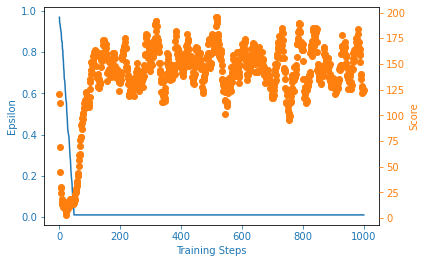

In [4]:
from utils import plot_learning_curve
x = [i+1 for i in range(n_games)]
filename = 'Phil-deepQ2.png'
plot_learning_curve(x, scores, eps_history, filename)


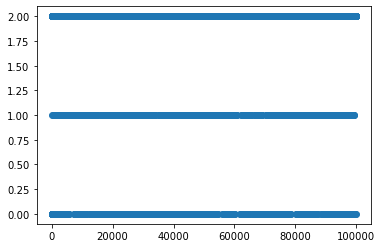

In [5]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(len(agent.action_memory)),agent.action_memory)

In [6]:
agent.Q_eval.load_state_dict(T.load(state_dict_path)) # load saved model

<All keys matched successfully>

In [7]:
print(agent.state_memory[-4:],
        agent.new_state_memory[-4:], 
        agent.action_memory[-4:], 
        agent.reward_memory[-4:], 
        agent.terminal_memory[-4:])

[[  2.          0.        287.40677     3.0774865   3.061829    2.970269
    2.9024653   2.8178883]
 [  2.          0.        287.52435     3.0787456   3.070871    2.976834
    2.9082294   2.8220487]
 [  2.          0.        290.8593      3.1144557   3.0842853   2.985272
    2.914655    2.8265285]
 [  2.          0.        288.92462     3.0937393   3.0886116   2.992945
    2.9207966   2.8309922]] [[  2.          0.        287.52435     3.0787456   3.070871    2.976834
    2.9082294   2.8220487]
 [  2.          0.        290.8593      3.1144557   3.0842853   2.985272
    2.914655    2.8265285]
 [  2.          0.        288.92462     3.0937393   3.0886116   2.992945
    2.9207966   2.8309922]
 [  2.          0.        285.96375     3.062035    3.0852923   2.9991074
    2.9265835   2.8350487]] [2. 2. 2. 2.] [-0.10689034  0.11757938  3.3349788  -1.9347153 ] [False False False False]


In [8]:
tmp = agent.action_memory[-500:]
print('mean', np.mean(tmp))
print('max', np.max(tmp))
print('min', np.min(tmp))

mean 1.992
max 2.0
min 0.0


In [9]:
info

{'profit_iteration': 0.0400989123489889,
 'iterations': 2940,
 'long_return': 2.576732432695111}